# Histogram of Oriented Gradients

참고 :
- Histogram of Oriented Gradients explained using OpenCV, https://learnopencv.com/histogram-of-oriented-gradients/
- Object Detection for Dummies Part 1: Gradient Vector, HOG, and SS
, https://lilianweng.github.io/posts/2017-10-29-object-recognition-part-1/

## Image Gradient Vector

|||||
|-|-|-|-|
||Derivative|Directional Derivative|Gradient|
|Value type |Scalar|Scalar|Vector|
|Definition |The rate of change of a function $f(x,y,z, ... )$ at a point $(x_0,y_0,z_0, ... )$, which is the slope of the tangent line at the point.|The instantaneous rate of change of $f(x,y,z, ... )$ in the direction of an unit vector $\vec{u}$.|It points in the direction of the greatest rate of increase of the function, containing all the partial derivative information of a multivariable function.|

In the image processing, 
- we want to know the direction of colors changing from one extreme to the other (i.e. black to white on a grayscale image).
- Therefore, we want to measure “gradient” on pixels of colors.
- The gradient on an image is discrete because each pixel is independent and cannot be further split.

The image gradient vector is defined as 
- a metric for every individual pixel, containing the pixel color changes in both x-axis and y-axis.
- The definition is aligned with the gradient of a continuous multi-variable function, which is a vector of partial derivatives of all the variables.
- Suppose f(x, y) records the color of the pixel at location (x, y), the gradient vector of the pixel (x, y) is defined as follows:


$$
\nabla f(x,y) =
\begin{bmatrix}
g_x \\
g_y
\end{bmatrix}
=
\begin{bmatrix}
\frac{\partial f}{\partial x} \\
\frac{\partial f}{\partial y}
\end{bmatrix}
=
\begin{bmatrix}
f(x+1,y) - f(x-1,y) \\
f(x,y+1) - f(x,y-1)
\end{bmatrix} 
$$

There are two important attributes of an image gradient:

- ***Magnitude*** is the L2-norm of the vector, $g = \sqrt{g^2_x + g^2_y}$ .
- ***Direction*** is the arctangent of the ratio between the partial derivatives on two directions, $\theta=\arctan(\frac{g_y}{g_x})=\tan^{-1}(\frac{g_y}{g_x})$.

<center>
<figure>
    <img src='https://lilianweng.github.io/posts/2017-10-29-object-recognition-part-1/image-gradient-vector-pixel-location.png' width='50%'>
    <figcaption>
    Fig 1. To compute the gradient vector of a target pixel at location (x, y),
    we need to know the colors of its four neighbors (or eight surrounding pixels depending on the kernel).
    </figcaption>
</figure>
</center>


The gradient vector of the example in is:

$$
\nabla f =
\begin{bmatrix}
\frac{\partial f}{\partial x} \\
\frac{\partial f}{\partial y}
\end{bmatrix}
=
\begin{bmatrix}
f(x+1,y) - f(x-1,y) \\
f(x,y+1) - f(x,y-1)
\end{bmatrix} 
=
\begin{bmatrix}
55 - 105 \\
90 - 40
\end{bmatrix} 
=
\begin{bmatrix}
-50 \\
50
\end{bmatrix} 
$$

Thus,

- the ***magnitude*** is $\sqrt{50^2+(-50)^2}=70.7107$, and
- the ***direction*** is $\arctan{-50/50} = -45^\circ$ .

Repeating the gradient computation process for every pixel iteratively is too slow. Instead, it can be well translated into applying a convolution operator on the entire image matrix, labeled as $\mathbf{A}$ using one of the specially designed convolutional kernels.


Let’s start with the x-direction of the example in *Fig 1.* using the kernel $\begin{bmatrix} -1, 0, 1 \end{bmatrix}$ sliding over the x-axis; $\ast$ is the convolution operator:

\begin{align*}
\mathbf{G}_x &= 
[-1, 0, 1] \ast [105, 255, 55] = -105 + 0 + 55 = -50
\end{align*}

Similarly, on the y-direction, we adopt the kernel $\begin{bmatrix} +1, 0, -1 \end{bmatrix}^\mathrm{T}$ :

\begin{align*}
\mathbf{G}_y &= 
[+1, 0, -1]^\mathrm{T} \ast
\begin{bmatrix}
  90\\
  255\\
  40
\end{bmatrix} 
= 90 + 0 - 40 = 50
\end{align*}

<center>
<figure>
    <img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/0*e-SMFTzO8r7skkpc'>
    <figcaption>Fig. Convolution Operation on a 7x7 matrix with a 3x3 kernel (<a href='https://medium.com/@bdhuma/6-basic-things-to-know-about-convolution-daef5e1bc411'>source</a>)
    </figcaption>
</figure>
</center>

Try this in python:

In [105]:
import numpy as np
import scipy.signal as sig
# data = np.array([[0, 105, 0], [40, 255, 90], [0, 55, 0]])
data = np.array([[1, 105, 2], [40, 255, 90], [2, 55, 1]])

data

array([[  1, 105,   2],
       [ 40, 255,  90],
       [  2,  55,   1]])

In [106]:
np.array([[-1, 0, 1]]).shape

(1, 3)

In [107]:
np.array([[-1], [0], [1]]).shape

(3, 1)

In [111]:
G_x = sig.correlate2d(data, np.array([[-1, 0, 1]]), mode='valid') 
G_y = sig.correlate2d(data, np.array([[-1], [0], [1]]), mode='valid')

# G_x = sig.convolve2d(data, np.array([[-1, 0, 1]]), mode='valid') 
# G_y = sig.convolve2d(data, np.array([[-1], [0], [1]]), mode='valid')

In [112]:
print(G_x)

[[ 1]
 [50]
 [-1]]


In [113]:
print(G_y)

[[  1 -50  -1]]


These two functions return `array([[0], [-50], [0]])` and `array([[0, 50, 0]])` respectively. (Note that in the numpy array representation, 40 is shown in front of 90, so -1 is listed before 1 in the kernel correspondingly.)

## Common Image Processing Kernels

<a href='https://en.wikipedia.org/wiki/Prewitt_operator' target='_new'>**Prewitt operator**:</a> Rather than only relying on four directly adjacent neighbors, the Prewitt operator utilizes eight surrounding pixels for smoother results.

$$
\mathbf{G}_x = \begin{bmatrix}
-1 & 0 & +1 \\
-1 & 0 & +1 \\
-1 & 0 & +1
\end{bmatrix} \ast \mathbf{A} \text{ and }
\mathbf{G}_y = \begin{bmatrix}
+1 & +1 & +1 \\
0 & 0 & 0 \\
-1 & -1 & -1
\end{bmatrix} \ast \mathbf{A}
$$

<a href='https://en.wikipedia.org/wiki/Sobel_operator' target='_new'>**Sobel operator**</a>: To emphasize the impact of directly adjacent pixels more, they get assigned with higher weights.

$$
\mathbf{G}_x = \begin{bmatrix}
-1 & 0 & +1 \\
-2 & 0 & +2 \\
-1 & 0 & +1
\end{bmatrix} \ast \mathbf{A} \text{ and }
\mathbf{G}_y = \begin{bmatrix}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix} \ast \mathbf{A}
$$


Different kernels are created for different goals, such as edge detection, blurring, sharpening and many more. Check <a href='https://en.wikipedia.org/wiki/Kernel_(image_processing)'>this wiki page</a> for more examples and references.

## Example: Manu in 2004

Let’s run a simple experiment on the photo of Manu Ginobili in 2004 when he still had a lot of hair. For simplicity, the photo is converted to grayscale first. For colored images, we just need to repeat the same process in each color channel respectively.

<figure>
    <img src='https://lilianweng.github.io/posts/2017-10-29-object-recognition-part-1/manu-2004.png'>
    <figurecaption>Fig 2. Manu Ginobili in 2004 with hair. (Image source: <a href="http://ftw.usatoday.com/2013/05/manu-ginobilis-bald-spot-through-the-years" target="_blank">Manu Ginobili's bald spot through the years</a>)</figurecaption>
</figure>

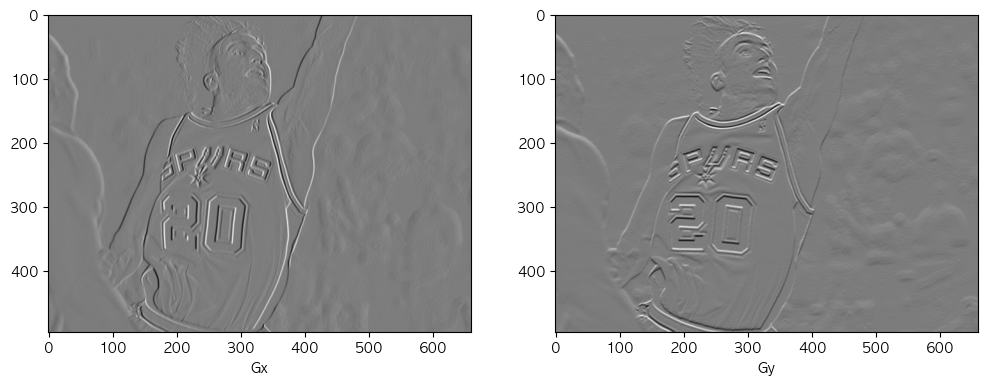

Fig 3. Apply Sobel operator kernel on the example image.


In [45]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import scipy.signal as sig
import matplotlib.pyplot as plt
# With mode="L", we force the image to be parsed in the grayscale, so it is
# actually unnecessary to convert the photo color beforehand.

url = 'https://ftw.usatoday.com/gcdn/authoring/images/smg/2025/03/10/SFTW/82207083007-90-2005-manu1.jpeg'
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("L")  # 흑백 모드
img = np.array(img)

# Define the Sobel operator kernels.
# kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
# kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# G_x = sig.convolve2d(img, kernel_x, mode='same') 
# G_y = sig.convolve2d(img, kernel_y, mode='same') 

kernel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
kernel_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

G_x = sig.convolve2d(img, kernel_x, mode='same', boundary='symm')
G_y = sig.convolve2d(img, kernel_y, mode='same', boundary='symm')

# Plot them!
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Actually plt.imshow() can handle the value scale well even if I don't do 
# the transformation (G_x + 255) / 2.
ax1.imshow((G_x + 255) / 2, cmap='gray'); 
ax1.set_xlabel("Gx")

ax2.imshow((G_y + 255) / 2, cmap='gray'); 
ax2.set_xlabel("Gy")

plt.show()
print("Fig 3. Apply Sobel operator kernel on the example image.")


You might notice that most area is in gray. Because the difference between two pixel is between -255 and 255 and we need to convert them back to [0, 255] for the display purpose. A simple linear transformation $(\mathbf{G} + 255) / 2$ would interpret all the zeros (i.e., constant colored background shows no change in gradient) as 125 (shown as gray).

## How HOG works

1. Preprocess the image, including resizing and color normalization.
2. Compute the gradient vector of every pixel, as well as its magnitude and direction.
3. Divide the image into many 8x8 pixel cells. In each cell, the magnitude values of these 64 cells are binned and cumulatively added into 9 buckets of unsigned direction (no sign, so 0-180 degree rather than 0-360 degree; this is a practical choice based on empirical experiments).
  
   A bin is selected based on the direction, and the vote ( the value that goes into the bin ) is selected based on the magnitude. Let’s first focus on the pixel encircled in blue. It has an angle ( direction ) of 80 degrees and magnitude of 2. So it adds 2 to the 5th bin. The gradient at the pixel encircled using red has an angle of 10 degrees and magnitude of 4. Since 10 degrees is half way between 0 and 20, the vote by the pixel splits evenly into the two bins.

6. Then we slide a 2x2 cells (thus 16x16 pixels) block across the image. In each block region, 4 histograms of 4 cells are concatenated into one-dimensional vector of 36 values and then normalized to have an unit weight. The final HOG feature vector is the concatenation of all the block vectors. It can be fed into a classifier like SVM for learning object recognition tasks.

This interesting configuration makes the histogram much more stable when small distortion is applied to the image.


<figure>
    <img src='https://learnopencv.com/wp-content/uploads/2016/12/hog-cell-gradients.png'>
    <figcaption>Fig 4. Center : The RGB patch and gradients represented using arrows. Right : The gradients in the same patch represented as numbers

</figcaption>
</figure>


<figure>
    <img src='https://lilianweng.github.io/posts/2017-10-29-object-recognition-part-1/HOG-histogram-creation.png'>
    <figcaption>Fig 5. How to split one gradient vector's magnitude if its degress is between two degree bins. (<a href='https://www.learnopencv.com/histogram-of-oriented-gradients'>source</a>)
</figcaption>
</figure>


## Example: Manu in 2004

Let’s reuse the same example image in the previous section. Remember that we have computed $\mathbf{G}_x$ and $\mathbf{G}_y$ for the whole image.

The following code simply calls the functions to construct a histogram and plot it.

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

N_BUCKETS = 9
CELL_SIZE = 8   # Each cell is 8x8 pixels
BLOCK_SIZE = 2  # Each block is 2x2 cells

def assign_bucket_vals(m, d, bucket_vals):
    left_bin = int(d / 20.)
    right_bin = (left_bin + 1) % N_BUCKETS
    
    # 보간값 계산
    left_val = m * (right_bin * 20 - d) / 20
    right_val = m * (d - left_bin * 20) / 20
    
    bucket_vals[left_bin] += left_val
    bucket_vals[right_bin] += right_val

def get_magnitude_hist_cell(loc_x, loc_y, G_x, G_y):
    # (loc_x, loc_y) defines the top left corner of the target cell.
    cell_x = G_x[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]
    cell_y = G_y[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]
    
    magnitudes = np.sqrt(cell_x * cell_x + cell_y * cell_y)
    directions = np.mod(np.arctan2(cell_y, cell_x) * 180 / np.pi, 180)  # [0,180)
    
    bucket_vals = np.zeros(N_BUCKETS)
    for m, d in zip(magnitudes.flatten(), directions.flatten()):
        assign_bucket_vals(m, d, bucket_vals)
    
    return bucket_vals

def get_magnitude_hist_block(loc_x, loc_y, G_x, G_y):
    # (loc_x, loc_y) defines the top left corner of the target block.
    return reduce(
        lambda arr1, arr2: np.concatenate((arr1, arr2)),
        [get_magnitude_hist_cell(x, y, G_x, G_y) for x, y in zip(
            [loc_x, loc_x + CELL_SIZE, loc_x, loc_x + CELL_SIZE],
            [loc_y, loc_y, loc_y + CELL_SIZE, loc_y + CELL_SIZE],
        )]
    )

In [115]:
# ------------------------------------------
url = 'https://ftw.usatoday.com/gcdn/authoring/images/smg/2025/03/10/SFTW/82207083007-90-2005-manu1.jpeg'
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("L")  # 흑백 모드
img = np.array(img)

# Define the Sobel operator kernels.
kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

G_x = sig.convolve2d(img, kernel_x, mode='same', boundary='symm')
G_y = sig.convolve2d(img, kernel_y, mode='same', boundary='symm')


# Random location [200, 200] as an example.
loc_x = loc_y = 0

ydata = get_magnitude_hist_block(loc_x, loc_y, G_x, G_y)

norm = np.linalg.norm(ydata)
if norm > 0:
    ydata = ydata / norm

xdata = range(len(ydata))
bucket_names = np.tile(np.arange(N_BUCKETS), BLOCK_SIZE * BLOCK_SIZE)

assert len(ydata) == N_BUCKETS * (BLOCK_SIZE * BLOCK_SIZE)
assert len(bucket_names) == len(ydata)

print("Block vector shape:", ydata.shape)
print("Block vector values:\n", ydata)

Block vector shape: (36,)
Block vector values:
 [ 0.2526479   0.          0.          0.          0.01804628  0.03454595
  0.02798481  0.04785242  0.          0.69022425  0.          0.
  0.          0.09023139  0.09023139  0.03190161  0.09570484 -0.46100442
  0.2526479   0.          0.          0.          0.12632395  0.12632395
  0.01276065  0.03828194  0.          0.2526479   0.          0.
  0.012034    0.1608699   0.1608699   0.02798481  0.04785242  0.        ]


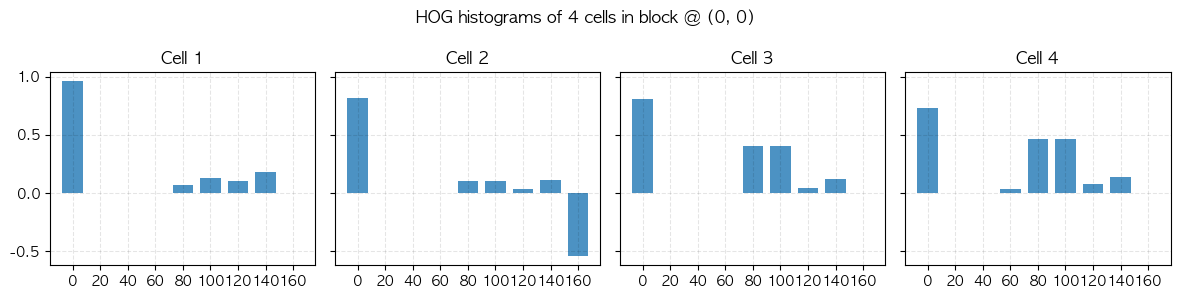

In [55]:
# plt.figure(figsize=(10, 3))
# plt.bar(xdata, ydata, align='center', alpha=0.8, width=0.9)
# plt.xticks(xdata, bucket_names * 20, rotation=90)
# plt.xlabel('Direction buckets')
# plt.ylabel('Magnitude')
# plt.grid(ls='--', color='k', alpha=0.1)
# plt.title("HOG of block at [%d, %d]" % (loc_x, loc_y))
# plt.tight_layout()
# plt.show()

fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharey=True)

cell_coords = [
    (loc_x, loc_y),
    (loc_x + CELL_SIZE, loc_y),
    (loc_x, loc_y + CELL_SIZE),
    (loc_x + CELL_SIZE, loc_y + CELL_SIZE),
]

for idx, (x, y) in enumerate(cell_coords):
    ydata = get_magnitude_hist_cell(x, y, G_x, G_y)
    norm = np.linalg.norm(ydata)
    if norm > 0:
        ydata = ydata / norm

    xdata = np.arange(N_BUCKETS) * 20
    axes[idx].bar(xdata, ydata, width=15, align='center', alpha=0.8)
    axes[idx].set_xticks(xdata)
    axes[idx].set_title(f"Cell {idx+1}")
    axes[idx].grid(ls='--', color='k', alpha=0.1)

plt.suptitle(f"HOG histograms of 4 cells in block @ ({loc_x}, {loc_y})")
plt.tight_layout()
plt.show()